In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as la
from scipy.stats import zscore
import seaborn as sns
from tqdm import trange
import biosfa
import math

In [2]:
rg = np.random.default_rng(0)
T = 24

In [3]:
file = open('data.txt', 'r')
lines = file.read().splitlines()
y = np.array(lines).astype(np.float)
y = y[0:T]

In [4]:
y1_lower = 0
y1_upper = 25
y2_lower = -100
y2_upper = 100
y1_abs = abs(y1_lower) + abs(y1_upper)
y2_abs = abs(y2_lower) + abs(y2_upper)
y1 = np.interp(y, (y.min(), y.max()), (y1_lower, y1_upper))
y2 = np.interp(y, (y.min(), y.max()), (y2_lower, y2_upper))

In [5]:
x = np.linspace(1, len(y), len(y))

In [6]:
np.random.seed(1)
gaussian_noise = np.random.normal(0.0, 15, len(x),)
y1_noise = y1 + gaussian_noise
gaussian_noise = np.random.normal(0.0, 10, len(x))
y2_noise = y2 + gaussian_noise

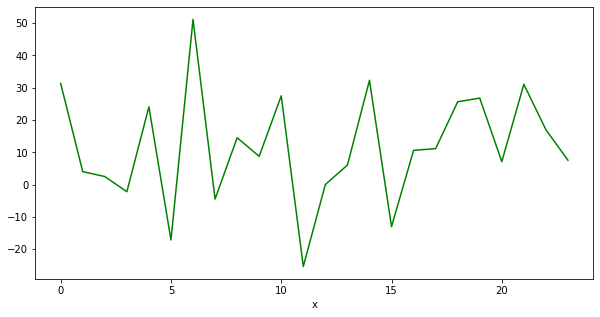

In [7]:
plt.figure(figsize=(10,5))
plt.plot((y1_noise), "g", ms=2.5, label="Device 1 measurements")
plt.xlabel('x')
plt.show()

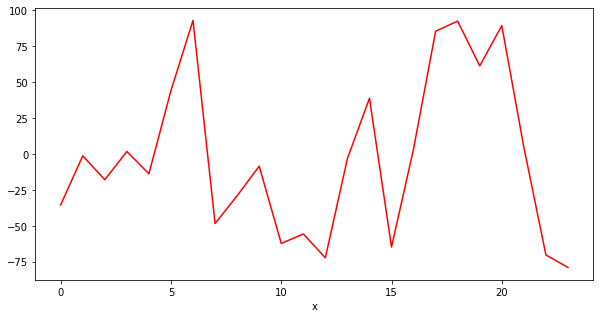

In [8]:
plt.figure(figsize=(10,5))
plt.plot((y2_noise), "r", ms=2.5, label="Device 2 measurements")
plt.xlabel('x')
plt.show()

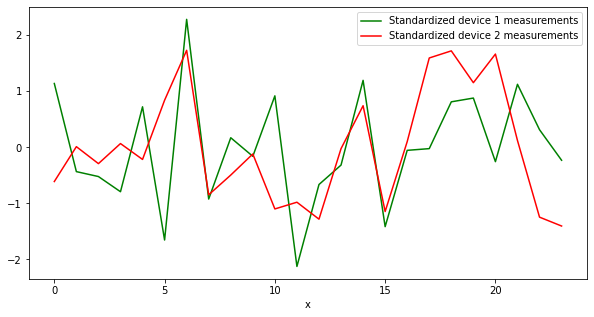

In [9]:
plt.figure(figsize=(10,5))
plt.plot(zscore(y1_noise), "g", ms=2.5, label="Standardized device 1 measurements")
plt.plot(zscore(y2_noise), "r", ms=2.5, label="Standardized device 2 measurements")
plt.xlabel('x')
plt.legend()
plt.show()

In [10]:
f = zscore(y1_noise)
s = zscore(y2_noise)
signal = np.zeros((T, 2))
for i in range(len(signal)):
    signal[i][0] = (f[i])
    signal[i][1] = (s[i])

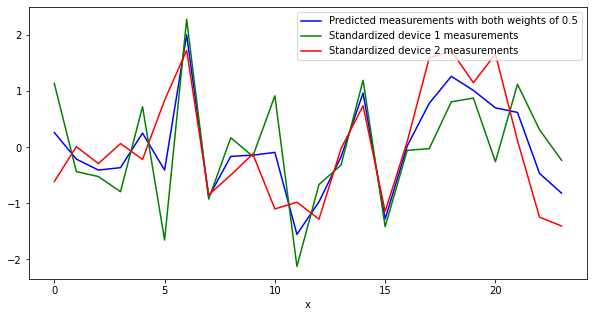

In [11]:
plt.figure(figsize=(10,5))
plt.plot(0.5*f + 0.5*s, "b", ms=2.5, label="Predicted measurements with both weights of 0.5")
plt.plot(f, "g", ms=2.5, label="Standardized device 1 measurements")
plt.plot(s, "r", ms=2.5, label="Standardized device 2 measurements")
plt.xlabel('x')
plt.legend()
plt.show()

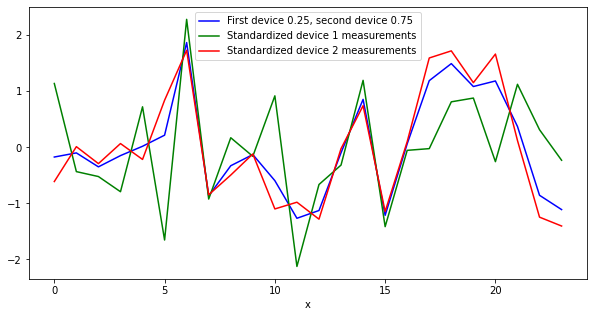

In [12]:
plt.figure(figsize=(10,5))
plt.plot(0.25*f + 0.75*s, "b", ms=2.5, label="First device 0.25, second device 0.75")
plt.plot(f, "g", ms=2.5, label="Standardized device 1 measurements")
plt.plot(s, "r", ms=2.5, label="Standardized device 2 measurements")
plt.xlabel('x')
plt.legend()
plt.show()

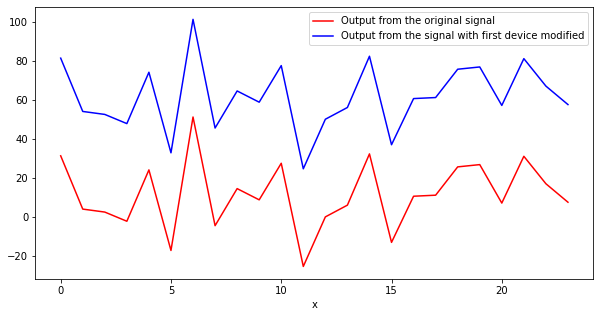

In [13]:
plt.figure(figsize=(10,5))
plt.plot(0.5 * (y1_noise) + 0.5 * (y1_noise), "r", ms=2.5, label="Output from the original signal")
plt.plot(0.5 * (y1_noise + 100) + 0.5 * (y1_noise), "b", ms=2.5, label="Output from the signal with first device modified")
plt.xlabel('x')
plt.legend()
plt.show()

In [14]:
X = np.zeros((2,T))
X[0:2,:] = signal.T

X_dot = X[:,1:T] - X[:,0:T-1]

Cxx = np.cov(X)
Cxx_dot = np.cov(X_dot)

evals_dot, evecs_dot = la.eigh(Cxx_dot, Cxx)

slow_gevp = evecs_dot[:,0] @ X

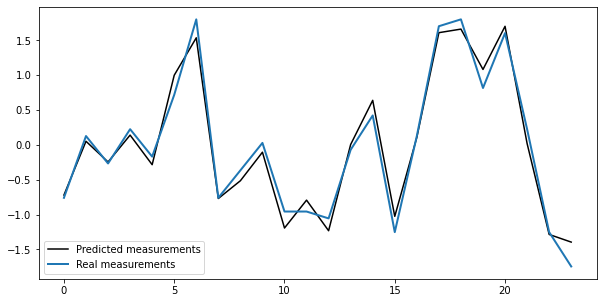

In [15]:
plt.figure(figsize=(10, 5))
gevp_plot = (slow_gevp[-T:])
plt.plot(-gevp_plot * np.sign(gevp_plot[0]), "k", label="Predicted measurements")
plt.plot(zscore(y), lw=2, label="Real measurements")
plt.legend()
plt.show()

In [16]:
#Slowness with both weights 0.5
series = zscore(0.5*f + 0.5*s)
slowness = 0
for i in range(1, len(series), 1):
    slowness += (series[i] - series[i-1])**2
print(slowness/len(series))

1.774197292312797


In [17]:
#Slowness with the first weight 0.25 and the second 0.75
series = zscore(0.25*f + 0.75*s)
slowness = 0
for i in range(1, len(series), 1):
    slowness += (series[i] - series[i-1])**2
print(slowness/len(series))

1.2544744731499666


In [18]:
#Slowness of the predicted signal
series = slow_gevp
slowness = 0
for i in range(1, len(series), 1):
    slowness += (series[i] - series[i-1])**2
print(slowness/len(series))

0.9824442227505324


In [19]:
#RMSE with both weights 0.5
dif_sum = 0
y_true = zscore(y)
pred = zscore((0.5*f + 0.5*s))
for i in range(len(pred)):
    dif_sum += (pred[i] - y_true[i])**2
rmse = math.sqrt(dif_sum/len(pred))
print(rmse)

0.6119714070180792


In [20]:
#RMSE with the first weight 0.25 and the second 0.75
dif_sum = 0
y_true = zscore(y)
pred = zscore((0.25*f + 0.75*s))
for i in range(len(pred)):
    dif_sum += (pred[i] - y_true[i])**2
rmse = math.sqrt(dif_sum/len(pred))
print(rmse)

0.31707387595625786


In [21]:
#RMSE of the predicted signal
dif_sum = 0
y_true = zscore(y)
for i in range(len(slow_gevp)):
    dif_sum += (-slow_gevp[i] - y_true[i])**2
rmse = math.sqrt(dif_sum/len(slow_gevp))
rmse

0.1721297813373716